# Setup

In [1]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

root_path = Path("/home/olivieri/exp").resolve()
src_path = root_path / "src"
sys.path.append(f"{str(src_path)}")

In [2]:
import pandas as pd
from glob import glob
import os

from prompter import *
from data import *

In [3]:
# Setting
BY_MODEL = "LRASPP_MobileNet_V3"
IMAGE_RESIZING_MODE = "letterboxed"
OUTPUT_MODE = "freeform"
SPLIT_BY = "class-splitted"

In [4]:
root_exp_name = "test_class_split"

In [5]:
root_exp_path = get_selected_annots_path(BY_MODEL, IMAGE_RESIZING_MODE, OUTPUT_MODE, SPLIT_BY) / "eval_prs" / root_exp_name

# exps_path = glob(f"{root_exp_path}/*")
exps_path = glob(f"{root_exp_path}/*")[1:]
exps_names = [os.path.splitext(os.path.basename(path))[0] for path in exps_path]
exps_names

['class-splitted']

# Assessment

In [6]:
df_mean_pred_prs = pd.DataFrame()
df_mean_score_prs = pd.DataFrame()
df_mean_pred_prs_per_class = pd.DataFrame()
df_mean_score_prs_per_class = pd.DataFrame()

for exp_path, exp_name in zip(exps_path, exps_names):
    
    variation_paths = glob(f"{exp_path}/*.jsonl")
    variations_names = [os.path.splitext(os.path.basename(path))[0] for path in variation_paths]

    df_pred_prs = pd.DataFrame()
    df_score_prs = pd.DataFrame()
    df_pred_prs_per_class = pd.DataFrame()
    df_score_prs_per_class = pd.DataFrame()

    for variation_name in variations_names:
        eval_prs = get_many_eval_pr(BY_MODEL, IMAGE_RESIZING_MODE, OUTPUT_MODE, SPLIT_BY, f"{root_exp_name}/{exp_name}", variation_name, return_state=False)

        _df_all_prs = pd.DataFrame.from_dict(eval_prs, orient='index')
            
        _df_pred_prs = _df_all_prs.map(lambda x: x["pred"] == "correct" if type(x) == dict else None).mean(axis=1).astype(float)
        _df_score_prs = _df_all_prs.map(lambda x: x["score"] if type(x) == dict else None).mean(axis=1).astype(float)
        _df_pred_prs_per_class = _df_all_prs.map(lambda x: x["pred"] == "correct" if type(x) == dict else None).mean(axis=0).astype(float)
        _df_score_prs_per_class = _df_all_prs.map(lambda x: x["score"] if type(x) == dict else None).mean(axis=0).astype(float)
        
        df_pred_prs = pd.concat([df_pred_prs, _df_pred_prs], axis=1)
        df_score_prs = pd.concat([df_score_prs, _df_score_prs], axis=1)
        df_pred_prs_per_class = pd.concat([df_pred_prs_per_class, _df_pred_prs_per_class], axis=1)
        df_score_prs_per_class = pd.concat([df_score_prs_per_class, _df_score_prs_per_class], axis=1)

    df_pred_prs.columns = variations_names
    df_score_prs.columns = variations_names
    df_pred_prs_per_class.columns = variations_names
    df_score_prs_per_class.columns = variations_names

    df_mean_pred_prs = pd.concat([df_mean_pred_prs, df_pred_prs.mean(axis=0)], axis=1)
    df_mean_score_prs = pd.concat([df_mean_score_prs, df_score_prs.mean(axis=0)], axis=1)
    df_mean_pred_prs_per_class = pd.concat([df_mean_pred_prs_per_class, df_pred_prs_per_class.mean(axis=1)], axis=1)
    df_mean_score_prs_per_class = pd.concat([df_mean_score_prs_per_class, df_score_prs_per_class.mean(axis=1)], axis=1)

df_mean_pred_prs.columns = exps_names
df_mean_score_prs.columns = exps_names
df_mean_pred_prs_per_class.columns = exps_names
df_mean_score_prs_per_class.columns = exps_names

## Pred

,mean,std,min,max
ConcatMasks_Sc_Hz,0.741667,0.352414,0.0,1.0
ConcatMasks_Sc_Vr,0.845833,0.276088,0.0,1.0
ConcatMasks_Ovr_Hz,0.712500,0.378009,0.0,1.0
ConcatMasks_Ovr_Vr,0.754167,0.366223,0.0,1.0
ConcatMasks_NoSc_Hz,0.875000,0.319333,0.0,1.0
ConcatMasks_NoSc_Vr,0.766667,0.420248,0.0,1.0
SepMasks_NoSc,0.883333,0.265458,0.0,1.0
SepMasks_Ovr,0.641667,0.405644,0.0,1.0
SepMasks_Sc,0.616667,0.429538,0.0,1.0
ArrayMasks_Imgs,0.770833,0.371573,0.0,1.0


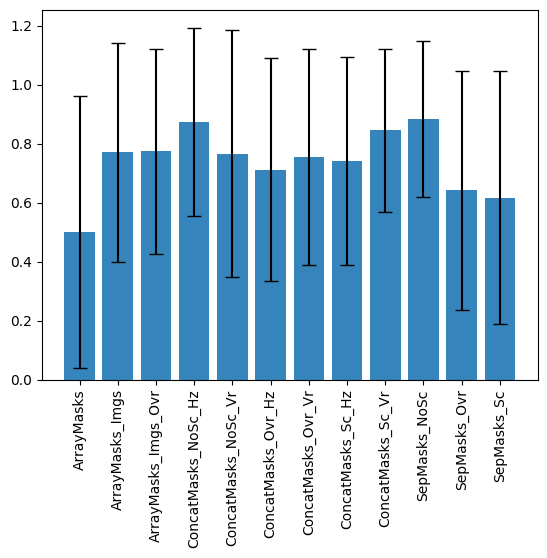

In [12]:
display(df_pred_prs.describe().sort_index().transpose()[["mean", "std", "min", "max"]])
mean = df_pred_prs.transpose().sort_index().mean(axis=1)
std = df_pred_prs.transpose().sort_index().std(axis=1)
plt.bar(mean.index, mean, yerr=std, capsize=5, alpha=0.9)
plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.show()

In [8]:
df_mean_pred_prs.describe().iloc[[1, 2, 3, 7]]

,class-splitted
mean,0.740278
std,0.111313
min,0.500000
max,0.883333


## Score

In [9]:
display(df_score_prs.describe().sort_index().transpose()[["mean", "std", "min", "max"]])

,mean,std,min,max
ConcatMasks_Sc_Hz,3.508333,1.072619,2.0,5.0
ConcatMasks_Sc_Vr,3.825000,0.869353,1.0,5.0
ConcatMasks_Ovr_Hz,3.558333,0.988642,2.0,5.0
ConcatMasks_Ovr_Vr,3.662500,1.007456,2.0,5.0
ConcatMasks_NoSc_Hz,4.041667,0.754858,2.0,5.0
ConcatMasks_NoSc_Vr,3.683333,1.086736,2.0,5.0
SepMasks_NoSc,4.095833,0.777646,2.0,5.0
SepMasks_Ovr,3.262500,1.204668,1.0,5.0
SepMasks_Sc,3.462500,1.164934,2.0,5.0
ArrayMasks_Imgs,3.920833,0.911859,2.0,5.0


In [10]:
df_mean_score_prs.describe().iloc[[1, 2, 3, 7]]

,class-splitted
mean,3.634375
std,0.311279
min,3.025000
max,4.095833


## Per-Class

,mean,std,min,max
1,0.861111,0.171643,0.666667,1.00
11,0.666667,0.492366,0.000000,1.00
12,1.000000,0.000000,1.000000,1.00
14,0.750000,0.452267,0.000000,1.00
15,0.593750,0.226917,0.125000,0.75
17,0.583333,0.288675,0.000000,1.00
18,0.750000,0.452267,0.000000,1.00
19,0.833333,0.224733,0.333333,1.00
2,0.250000,0.452267,0.000000,1.00
20,0.916667,0.194625,0.500000,1.00


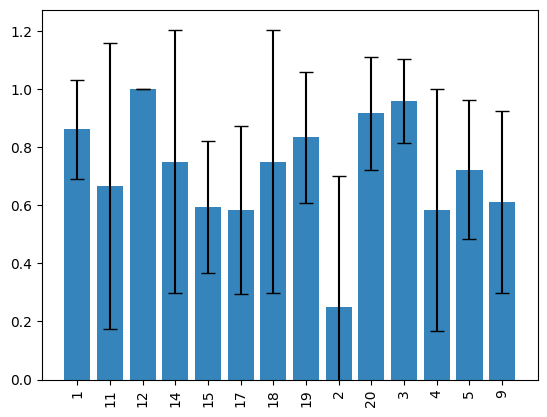

In [11]:
display(df_pred_prs_per_class.transpose().describe().transpose()[["mean", "std", "min", "max"]].sort_index())
mean = df_pred_prs_per_class.transpose().mean().sort_index()
std = df_pred_prs_per_class.transpose().std().sort_index()
plt.bar(mean.index, mean, yerr=std, capsize=5, alpha=0.9)
plt.ylim(bottom=0)
plt.xticks(rotation=90)
plt.show()